# How to fit double gaussian with Roofit in python

Some links:
- Download rootnotes here: https://gist.github.com/mazurov/6194738
- Example of using roofit in notebook: https://www.nikhef.nl/~vcroft/GettingStartedWithRooFit.html
- Roofit tutorial (both C++ and python): https://root.cern.ch/doc/master/group__tutorial__roofit.html


In [1]:
import ROOT

Welcome to JupyROOT 6.18/04


In [2]:
import rootnotes

In [3]:
canvas = rootnotes.default_canvas()

In [4]:
file = ROOT.TFile("lambda_small.root")

In [5]:
file.ls()

TFile**		lambda_small.root	
 TFile*		lambda_small.root	
  KEY: TTree	lambda;1	lambda


In [6]:
tree = file.Get('lambda')

In [7]:
tree.Print()

******************************************************************************
*Tree    :lambda    : lambda                                                 *
*Entries :  1522775 : Total =        30546180 bytes  File  Size =   13857895 *
*        :          : Tree compression factor =   2.20                       *
******************************************************************************
*Br    0 :M         : M/D                                                    *
*Entries :  1522775 : Total  Size=   12216877 bytes  File Size  =    5807645 *
*Baskets :      382 : Basket Size=      32000 bytes  Compression=   2.10     *
*............................................................................*
*Br    1 :mva       : mva/F                                                  *
*Entries :  1522775 : Total  Size=    6108969 bytes  File Size  =    5656891 *
*Baskets :      191 : Basket Size=      32000 bytes  Compression=   1.08     *
*...................................................

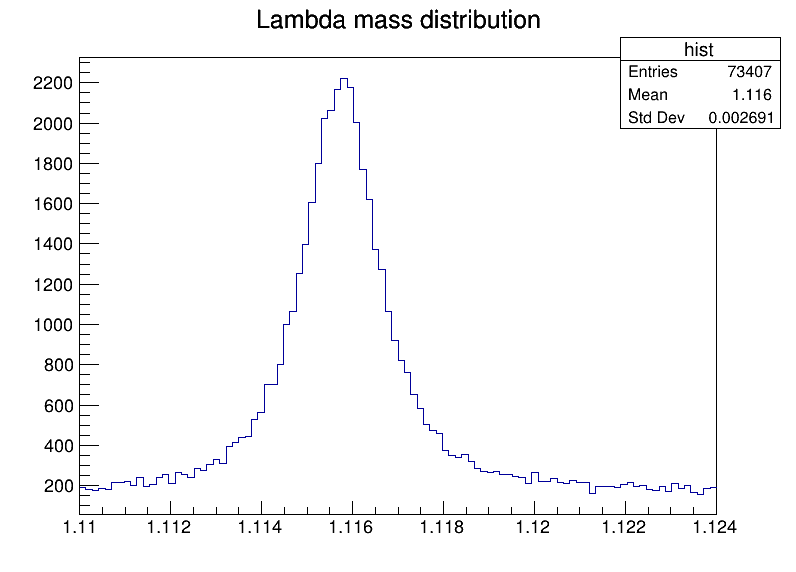

Info in <TCanvas::Print>: png file /tmp/tmprem33rzt.png has been created


In [8]:
mass_min = 1.11
mass_max = 1.124

hist = ROOT.TH1F("hist", "Lambda mass distribution", 100, mass_min, mass_max)
tree.Draw("M >> hist", "mva > 0.5")
canvas

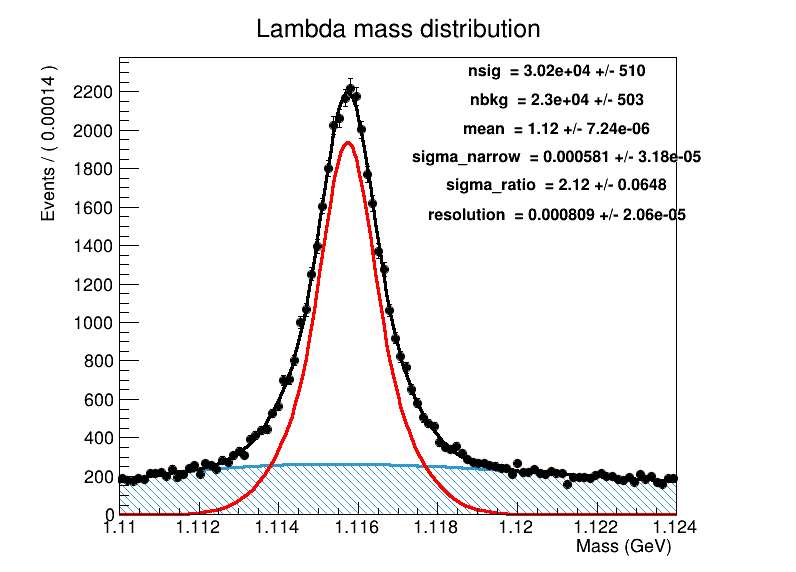

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (narrow_gaussian,wide_gaussian,che2)
 **********
 **   10 **SET PRINT           1
 **********
 **********
 **   11 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 c0           1.00000e-01  1.00000e+00   -5.00000e+00  5.00000e+00
     2 c1           1.00000e-02  1.00000e+00   -5.00000e+00  5.00000e+00
     3 c2           1.00000e-03  1.00000e+00   -5.00000e+00  5.00000e+00
     4 mean         1.11500e+00  2.00000e-04    1.11500e+00  1.11700e+00
 MINUIT WARNING IN PARAM DEF
 ============== STARTING VALUE IS AT LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE4 IS AT ITS LOWER ALLOWED LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VAR

Info in <TCanvas::Print>: pdf file lambda.pdf has been created
Info in <TCanvas::Print>: png file /tmp/tmpn9tcfevq.png has been created


In [12]:
title = 'Lambda mass distribution'
xlabel = 'Mass (GeV)'

x = ROOT.RooRealVar("mass", xlabel, mass_min, mass_max)
data = ROOT.RooDataHist("data", "data for the fit", ROOT.RooArgList(x), hist)
mean = ROOT.RooRealVar("mean", "center of the gaussian", 1.114, 1.115, 1.117)
sigma_narrow = ROOT.RooRealVar("sigma_narrow", "sigma of the narrow gaussian", 0.001, 0, 0.005)
sigma_ratio = ROOT.RooRealVar("sigma_ratio", "ratio of the wide sigma to narrow sigma", 2, 1, 5)
sigma_wide = ROOT.RooFormulaVar("sigma_wide", "wide sigma", "@0 * @1", ROOT.RooArgList(sigma_narrow, sigma_ratio))
narrow_frac = ROOT.RooRealVar("narrow_frac", "fraction of the signal in the narrow gaussian", 0.5, 0.0, 1.0)

narrow_gaussian = ROOT.RooGaussian("narrow_gaussian", "narrow gaussian", x, mean, sigma_narrow)
wide_gaussian = ROOT.RooGaussian("wide_gaussian", "wide gaussian", x, mean, sigma_wide)
double_gaussian = ROOT.RooAddPdf("double_gaussian", "double gaussian",
                                 ROOT.RooArgList(narrow_gaussian, wide_gaussian),
                                 ROOT.RooArgList(narrow_frac))
signal_pdf = double_gaussian

### BACKGROUND
c0 = ROOT.RooRealVar("c0", "c0", 0.1, -5, 5)
c1 = ROOT.RooRealVar("c1", "c1", 0.01, -5, 5)
c2 = ROOT.RooRealVar("c2", "c2", 0.001, -5, 5)
chebychev2 = ROOT.RooChebychev("che2", "2nd order chebychev", x, ROOT.RooArgList(c0, c1, c2))
background_pdf = chebychev2

nsig = ROOT.RooRealVar("nsig", "number of signals", 5e5, 0, 1e9)
nbkg = ROOT.RooRealVar("nbkg", "number of backgrounds", 5e5, 0, 1e9)

# resolution
res = ROOT.RooFormulaVar("res", "resolution", "sqrt((@0 * @1)^2 + (1 - @0)^2 * (@1 * @2)^2)", 
                         ROOT.RooArgList(narrow_frac, sigma_narrow, sigma_ratio))

model = ROOT.RooAddPdf("model", "signal and background distribution", 
                      ROOT.RooArgList(signal_pdf, background_pdf),
                      ROOT.RooArgList(nsig, nbkg))

fit = model.fitTo(data, ROOT.RooFit.Save())

##### Set up plotting styles. 
ROOT.gStyle.SetTitleY(0.98) # This line must go first otherwise left side will be clipped.
ROOT.gPad.SetLeftMargin(0.15)
ROOT.gPad.SetRightMargin(0.15)
ROOT.gPad.SetTopMargin(0.1)
ROOT.gPad.SetBottomMargin(0.1)

COLORS = [1, ROOT.kRed - 7, ROOT.kAzure + 5, ROOT.kGreen-2,  ROOT.kMagenta+1, ROOT.kYellow]
FILL_STYLES = [0, 1001, 3004,  3005, 3009, 3006]
LINEWIDTH = 3

##### Plot all the components are put statistics in a box
frame = x.frame(ROOT.RooFit.Title(title))
data.plotOn(frame)
sig_component = ROOT.RooArgSet(signal_pdf)
bkg_component = ROOT.RooArgSet(background_pdf)
all_components = ROOT.RooArgSet(signal_pdf, background_pdf)

model.plotOn(frame, ROOT.RooFit.Components(all_components), 
             ROOT.RooFit.LineColor(1),
             ROOT.RooFit.LineWidth(LINEWIDTH))
model.plotOn(frame, ROOT.RooFit.Components(sig_component), 
             ROOT.RooFit.LineColor(2),
             ROOT.RooFit.LineWidth(LINEWIDTH))
model.plotOn(frame, ROOT.RooFit.Components(bkg_component),
             ROOT.RooFit.FillColor(COLORS[2]), 
             ROOT.RooFit.LineColor(COLORS[2]),
             ROOT.RooFit.LineWidth(LINEWIDTH),
             ROOT.RooFit.FillStyle(FILL_STYLES[3]),
             ROOT.RooFit.DrawOption('FL'),
             ROOT.RooFit.MoveToBack())

params = [nsig, nbkg, mean, sigma_narrow, sigma_ratio]
stat = ROOT.TPaveText(0.5, 0.6, 0.9, 0.9, "NBNDC")
for p in params:
    stat.AddText(f'{p.GetName()}  = {p.getVal():.3g} +/- {p.getError():.3g}')
# Add resolution 
stat.AddText(f'resolution  = {res.getVal():.3g} +/- {res.getPropagatedError(fit):.3g}')
stat.SetTextSize(0.03)
stat.SetFillStyle(0)
stat.SetBorderSize(0)

# This line must go before the Draw()
frame.addObject(stat)
frame.Draw()

## Save figure as pdf
canvas.SaveAs('lambda.pdf')

canvas

In [13]:
fit.Print("v")


  RooFitResult: minimized FCN value: -774241, estimated distance to minimum: 9.72429e-06
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter  InitialValue    FinalValue +/-  Error     GblCorr.
  --------------------  ------------  --------------------------  --------
                    c0    1.0000e-01   -5.2873e-02 +/-  1.33e-02  <none>
                    c1    1.0000e-02   -1.9558e-01 +/-  2.58e-02  <none>
                    c2    1.0000e-03    5.1325e-02 +/-  1.85e-02  <none>
                  mean    1.1150e+00    1.1157e+00 +/-  7.24e-06  <none>
           narrow_frac    5.0000e-01    3.6498e-01 +/-  4.66e-02  <none>
                  nbkg    5.0000e+05    2.2964e+04 +/-  5.03e+02  <none>
                  nsig    5.0000e+05    3.0242e+04 +/-  5.10e+02  <none>
          sigma_narrow    1.0000e-03    5.8061e-04 +/-  3.18e-05  <none>
           sigma_ratio    2.0000e+00    2.1168e+00 +/-